In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Read file
data = pd.read_csv("./consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])

# Filter away helsingfors with less than 4.5 in consumption as it seems like noise.
mask = (data["location"]!= "helsingfors") | ((data["location"] == "helsingfors") & (data["consumption"] >= 4.5))
data = data[mask]

# Split into seperate dataframes for each city
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}


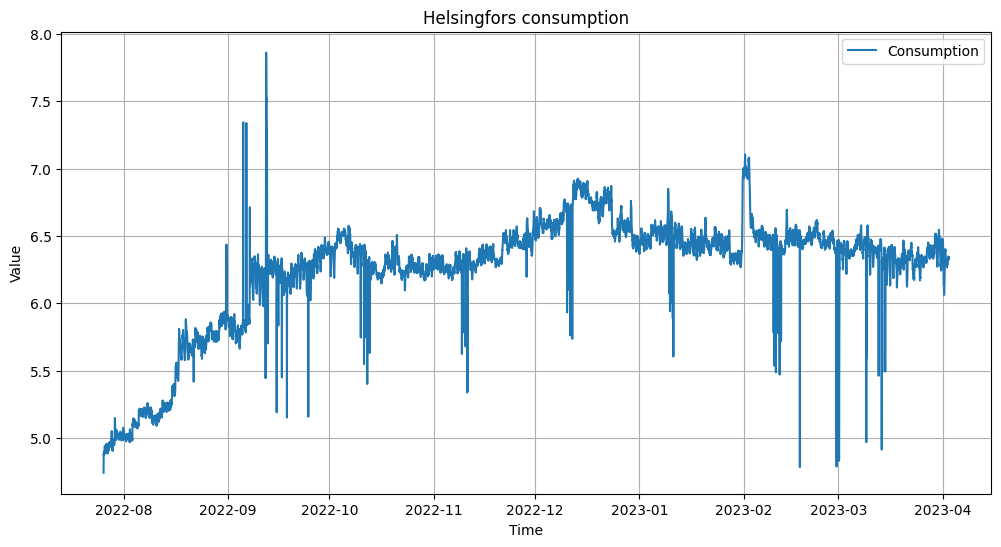

In [8]:
#plot helsingfors
plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

plt.plot(data[data['location']=='helsingfors']['time'], data[data['location']=='helsingfors']['consumption'], label='Consumption', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Helsingfors consumption')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
normalize_features = True

# Plot
# for city, city_data in data_cities.items():

#     # Normalize the "consumption" and "temperature" columns using Min-Max scaling
#     min_consumption = city_data['consumption'].min()
#     max_consumption = city_data['consumption'].max()
#     min_temperature = city_data['temperature'].min()
#     max_temperature = city_data['temperature'].max()

#     normalized_city_data = city_data.copy()
#     if normalize_features:
#         normalized_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
#         normalized_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))
    

#     # Print correlation matrix
#     print(f"Correlation: {normalized_city_data.drop(columns=['location', 'time']).corr()}")
#     # Plot
#     plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

#     plt.plot(normalized_city_data['time'], normalized_city_data['consumption'], label='Consumption', linestyle='-')
#     plt.plot(normalized_city_data['time'], normalized_city_data['temperature'], label='Temperature inverse', linestyle='-')

#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title(city)
#     plt.legend()
#     plt.grid(True)

#     plt.show()

# Machine learning model

c:\Users\Bruker\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Root Mean Squared Error (RMSE): 0.08324571862834265


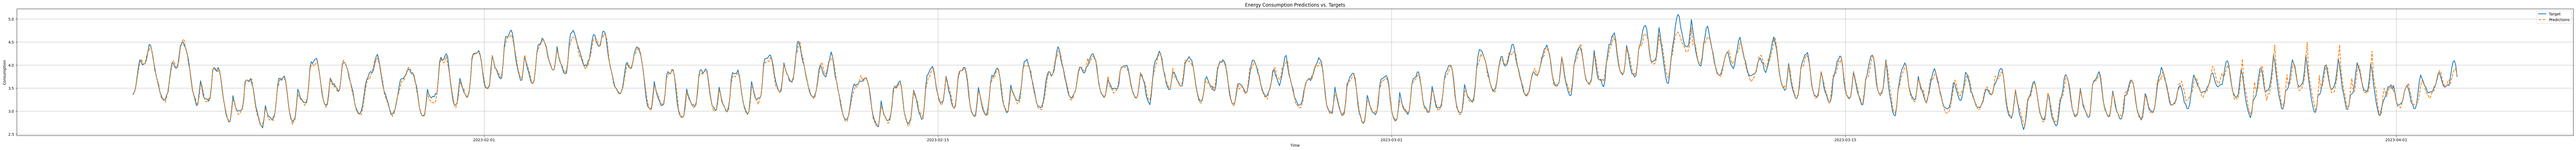

In [10]:
# XGBoost Model
import pandas as pd
import numpy as np


data_trondheim = data[data["location"] == "trondheim"].copy()
data_trondheim = data_trondheim.drop(columns="location")

# Perform time-based feature engineering
data_trondheim["hour"] = data_trondheim["time"].dt.hour
data_trondheim["day_of_week"] = data_trondheim["time"].dt.dayofweek
data_trondheim["month"] = data_trondheim["time"].dt.month
data_trondheim["day_of_year"] = data_trondheim["time"].dt.dayofyear

# Create lag features to capture seasonality
lags = [1, 7, 30]  # Daily, weekly, and monthly lags
for lag in lags:
    data_trondheim[f"lag_{lag}"] = data_trondheim["consumption"].shift(lag)

# Drop missing values generated by lag features
data_trondheim.dropna(inplace=True)

# Split the data into training and testing sets
X = data_trondheim.drop(["consumption", "time"], axis=1)
y = data_trondheim["consumption"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, shuffle=False
# )  # I suspect this overfits things
# Try again with my own logic:
X_train, X_test = X[:round(len(X)*0.8)], X[round(len(X)*0.8):]
y_train, y_test = y[:round(len(X)*0.8)], y[round(len(X)*0.8):]


# Normalize the features (optional, but often beneficial)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train an XGBoost model
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42,
)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the model's performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# You can now use the trained model to make predictions for future energy consumption.

# For hyperparameter tuning, you can use techniques like GridSearchCV or RandomizedSearchCV.

# Plotting the predictions vs. targets with time on the x-axis
plt.figure(figsize=(120, 6))
plt.plot(
    data_trondheim["time"].iloc[-len(y_test) :], y_test, label="Target", linewidth=2
)
plt.plot(
    data_trondheim["time"].iloc[-len(y_test) :],
    y_pred,
    label="Predictions",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.title("Energy Consumption Predictions vs. Targets")
plt.legend()
plt.grid(True)
plt.show()